In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets


In [2]:
class AccidentCNN(nn.Module):
    def __init__(self):
        super(AccidentCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  
        self.fc2 = nn.Linear(512, 2)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root='dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/val', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
model = AccidentCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)


AccidentCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [5]:

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

for epoch in range(10):  
    model.train()  
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()

    train_acc = correct / total

    avg_train_loss = train_loss / len(train_loader)

    model.eval()  
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()

    val_acc = correct / total

    avg_val_loss = val_loss / len(val_loader)

    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)


    print(f"Epoch {epoch+1}: Training Loss: {avg_train_loss:.3f} | Training Accuracy: {train_acc:.2f} Validation Loss: {avg_val_loss:.3f} | Validation Accuracy: {val_acc:.2f}")


Epoch 1: Training Loss: 1.449 | Training Accuracy: 0.75 Validation Loss: 0.514 | Validation Accuracy: 0.73
Epoch 2: Training Loss: 0.556 | Training Accuracy: 0.80 Validation Loss: 0.526 | Validation Accuracy: 0.80
Epoch 3: Training Loss: 0.385 | Training Accuracy: 0.86 Validation Loss: 0.461 | Validation Accuracy: 0.89
Epoch 4: Training Loss: 0.278 | Training Accuracy: 0.94 Validation Loss: 0.209 | Validation Accuracy: 0.89
Epoch 5: Training Loss: 0.207 | Training Accuracy: 0.96 Validation Loss: 0.323 | Validation Accuracy: 0.90
Epoch 6: Training Loss: 0.126 | Training Accuracy: 0.96 Validation Loss: 0.253 | Validation Accuracy: 0.89
Epoch 7: Training Loss: 0.142 | Training Accuracy: 0.97 Validation Loss: 0.240 | Validation Accuracy: 0.89
Epoch 8: Training Loss: 0.098 | Training Accuracy: 0.97 Validation Loss: 0.193 | Validation Accuracy: 0.90
Epoch 9: Training Loss: 0.097 | Training Accuracy: 0.98 Validation Loss: 0.270 | Validation Accuracy: 0.92
Epoch 10: Training Loss: 0.074 | Trai

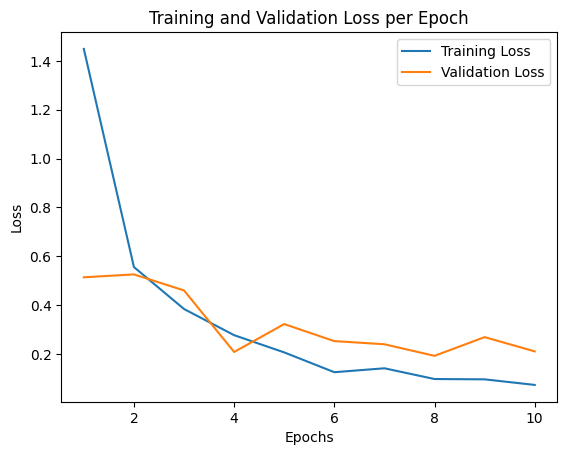

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, 11), training_losses, label='Training Loss')
plt.plot(range(1, 11), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

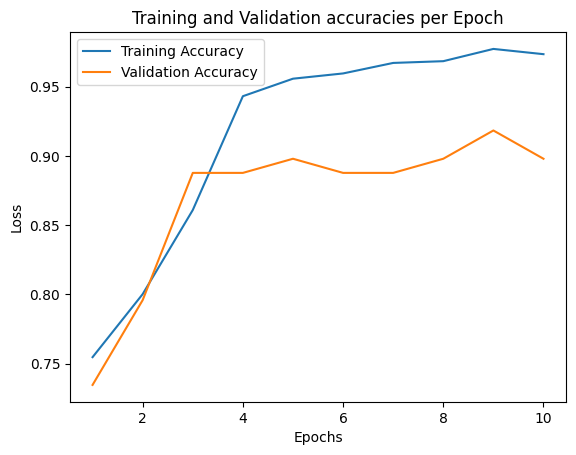

In [13]:
plt.plot(range(1, 11), training_accuracies, label='Training Accuracy')
plt.plot(range(1, 11), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation accuracies per Epoch')
plt.legend()
plt.show()

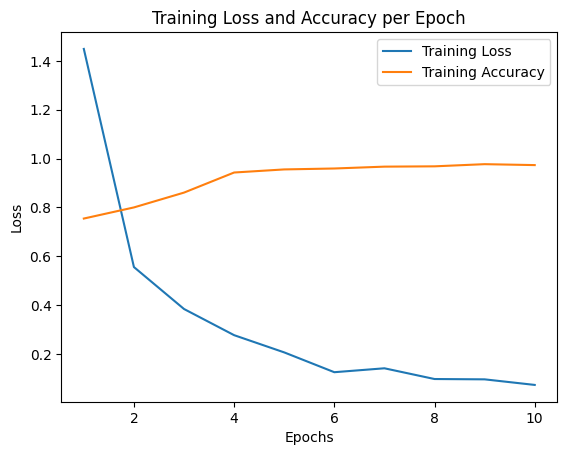

In [14]:
plt.plot(range(1, 11), training_losses, label='Training Loss')
plt.plot(range(1, 11), training_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss and Accuracy per Epoch')
plt.legend()
plt.show()

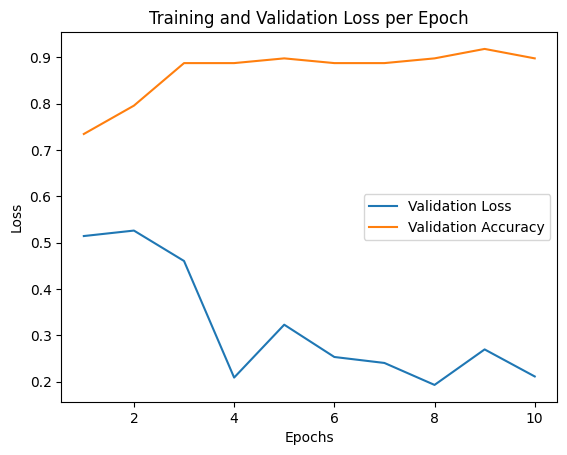

In [15]:
plt.plot(range(1, 11), validation_losses, label='Validation Loss')
plt.plot(range(1, 11), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # images = images.to(device)
        # labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total}%')


Accuracy of the network on the test images: 93%


In [20]:
from sklearn.metrics import f1_score
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
    
print(f'F1 score of the network on the test images: {f1_score(y_true, y_pred)}')

F1 score of the network on the test images: 0.9357798165137615


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.89      0.92        47
           1       0.91      0.96      0.94        53

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



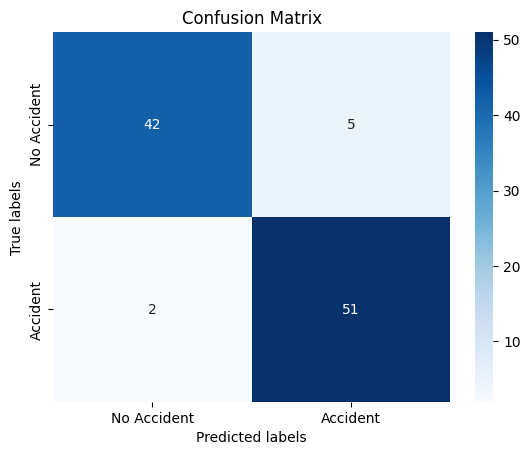

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Accident', 'Accident'])
ax.yaxis.set_ticklabels(['No Accident', 'Accident'])
plt.show()

In [24]:
model.to('cpu')

torch.save(model.state_dict(), 'accident_cnn.pt')